In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from python_package.qGAN import Discriminator, QuantumAnsatz, QuantumGenerator, model_training
from python_package.simulations import MonteCarlo as mcs
from python_package.metrics import FID, relative_entropy
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

In [3]:
# Set the random seed for reproducibility
seed = 24
torch.manual_seed(seed)
np.random.seed(seed)

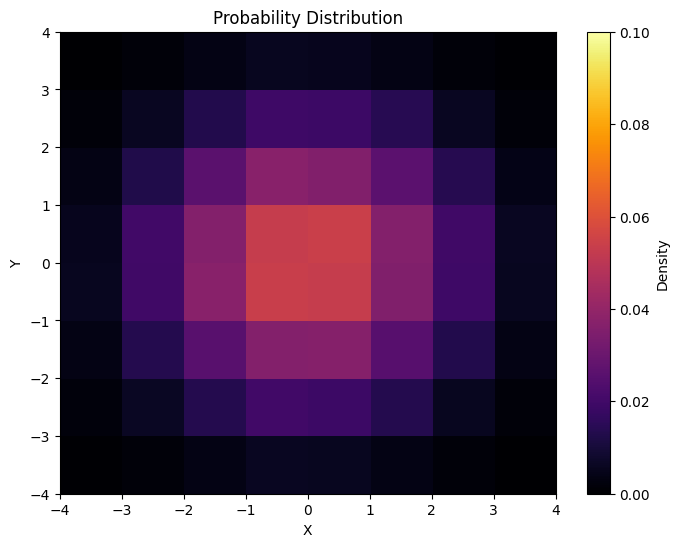

In [4]:
# 2D Random Walk simulation
final_positions = mcs.random_walk(n_samples=100000, n_steps=5)

# Get the pseudo probability distribution
prob_dist = mcs.probability_distribution_2D(samples=final_positions, batch_size=10000, bins=8, limits=(-5, 5))

# Visualize the probability distribution of the simulated data
mcs.visualize_distribution_2D(samples=final_positions, limits=(-4, 4), bins=8, vmax=0.1)

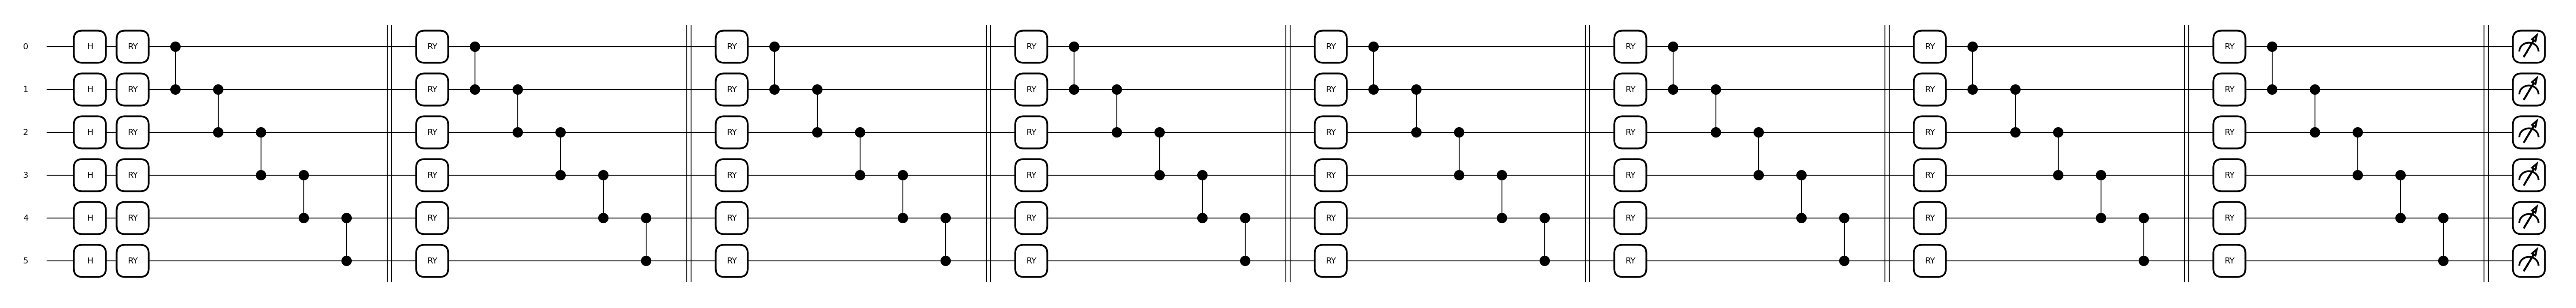

In [5]:
n_qubits = 6 # Number of qubits in the circuit
a_qubits = 0
q_depth = 8 # Number of layers in the circuit

# Visualization of the parametrized circuit
ansatz = QuantumAnsatz(n_qubits, q_depth)
ansatz.plot_circuit()

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialization of classical discriminator and Quantum generator
discriminator = Discriminator(input_shape=64, 
                              layers=[100, 20]).to(device)

generator = QuantumGenerator(total_qubits=n_qubits,
                             auxiliar_qubits=a_qubits, 
                             circuit_depth=q_depth, 
                             quantum_circuit=ansatz.circuit()).to(device)

# Discriminator features 
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=20, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


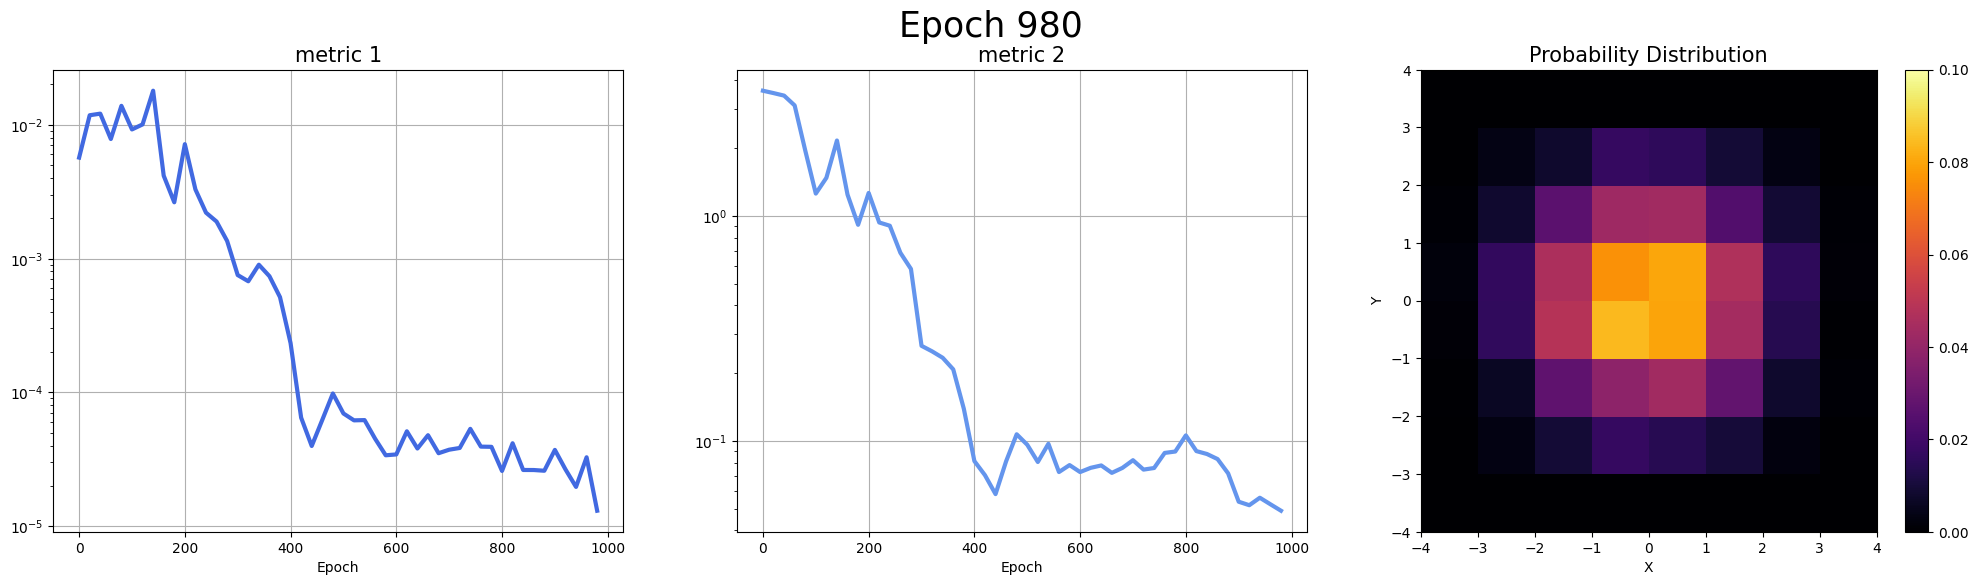

In [7]:
lrG = 0.5  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator

model_training(
    discriminator=discriminator,
    generator=generator,
    probability_distribution=prob_dist, 
    dist_shape=(8, 8),
    device=device, 
    criterion=nn.BCELoss(),
    disc_optimizer=optim.SGD(discriminator.parameters(), lr=lrD),
    gen_optimizer=optim.SGD(generator.parameters(), lr=lrG),
    metrics=[FID, relative_entropy],
    epochs=1000
)

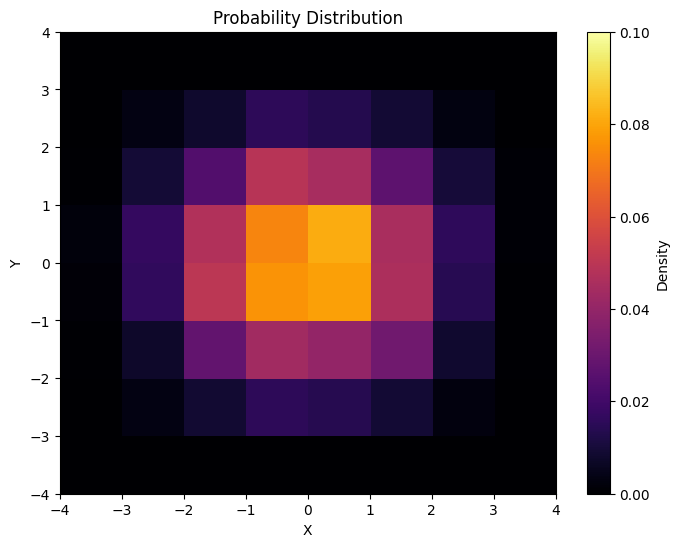

In [8]:
gen = generator.filtered_distribution(shots=100000)
gen_final_positions = np.stack([(gen//8) - 4, (gen%8) - 4]).T
mcs.visualize_distribution_2D(samples=gen_final_positions, limits=(-4, 4), bins=8, vmax=0.1)


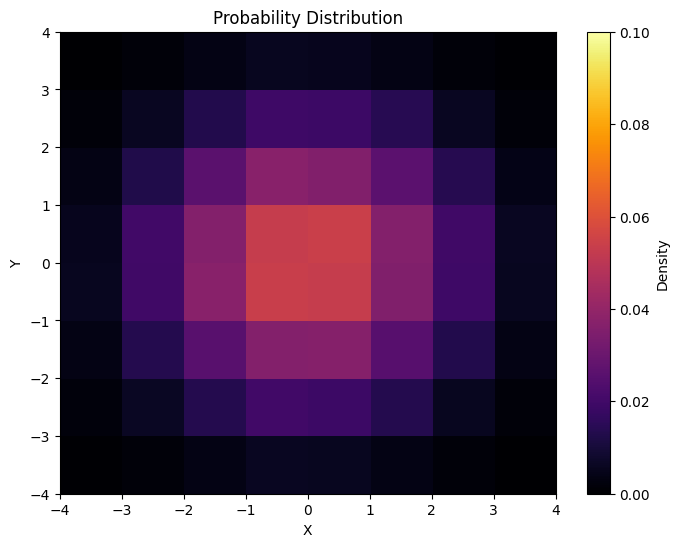

In [9]:
# Visualize the probability distribution of the simulated data
mcs.visualize_distribution_2D(samples=final_positions, limits=(-4, 4), bins=8, vmax=0.1)

In [10]:
# Get the pseudo probability distribution
real_dist = mcs.probability_distribution_2D(samples=final_positions, batch_size=100000, bins=8, limits=(-4, 4))
gen_dist = mcs.probability_distribution_2D(samples=gen_final_positions, batch_size=100000, bins=8, limits=(-4, 4))

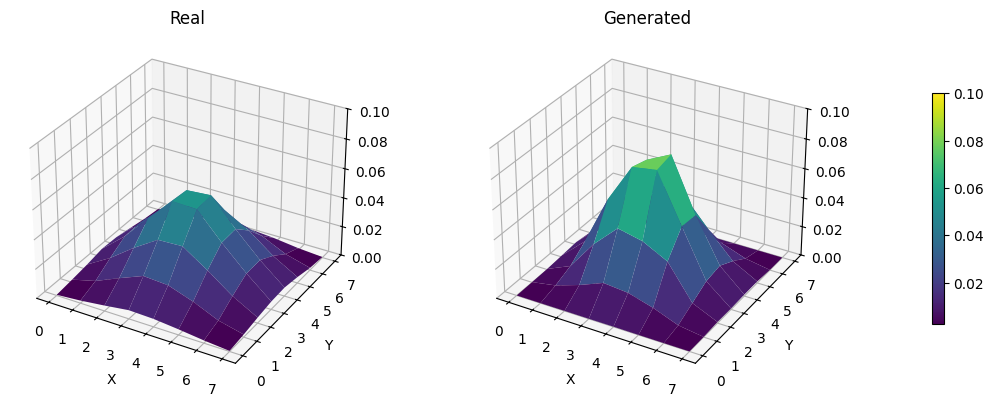

In [11]:
# Step 1: Create two 8x8 matrices
matrix1 = real_dist[0] 
matrix2 = gen_dist [0] 

# Step 2: Create the meshgrid
x = np.arange(8)
y = np.arange(8)
X, Y = np.meshgrid(x, y)

# Step 3: Find the z-axis limits to keep the same scale
z_min = min(matrix1.min(), matrix2.min())
z_max = max(matrix1.max(), matrix2.max())

# Step 4: Create the figure and subplots
fig = plt.figure(figsize=(14, 6))

# Create subplots using GridSpec
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], wspace=0.3)
ax1 = fig.add_subplot(gs[0], projection='3d')
ax2 = fig.add_subplot(gs[1], projection='3d')

# Plot the first matrix as a 3D surface
surf1 = ax1.plot_surface(X, Y, matrix1, cmap='viridis', vmax=0.1)
ax1.set_title('Real')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
#ax1.set_zlabel('Z-axis (Value)')
ax1.set_zlim(0, 0.1)  # Set the z-axis limits

# Plot the second matrix as a 3D surface
surf2 = ax2.plot_surface(X, Y, matrix2, cmap='viridis', vmax=0.1)
ax2.set_title('Generated')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
#ax2.set_zlabel('Z-axis (Value)')
ax2.set_zlim(0, 0.1)  # Set the z-axis limits

# Add a color bar that is shared between the two subplots
cbar = fig.colorbar(surf1, ax=[ax1, ax2], shrink=0.5, aspect=20, pad=0.1)
#cbar.set_label('Value')

plt.show()


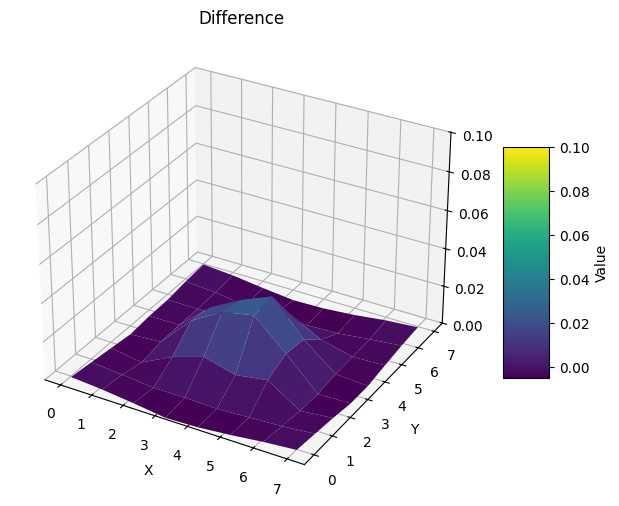

In [12]:
# Step 1: Create two 8x8 matrices
diff = gen_dist[0] - real_dist[0]

# Step 2: Create the meshgrid
x = np.arange(8)
y = np.arange(8)
X, Y = np.meshgrid(x, y)

# Step 3: Plot the matrix as a 3D surface
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, diff, cmap='viridis', vmax=0.1)

# Add a color bar and labels
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Value')
ax.set_title('Difference')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlim(0, 0.1)


plt.show()


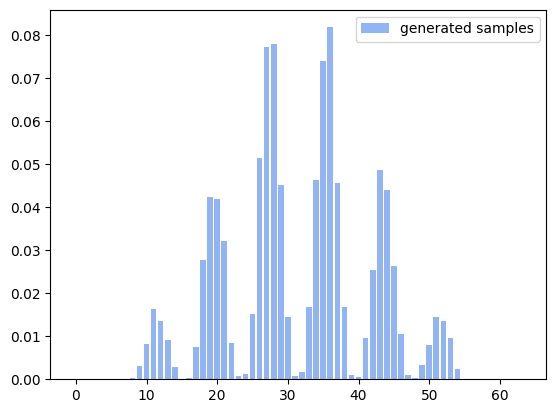

In [13]:
# Exclude states from the sampling
#excluded_states = [0, 10, 11, 12, 13, 14, 15]
gen = generator.filtered_distribution(shots=100000)

# Visualize distributions
# mcs.visualize_distribution_2D(samples=final_positions, limits=(-5, 5), bins=8)
# mcs.visualize_distribution_2D(samples=final_positions, limits=(-5, 5), bins=8)
#plt.hist(coin_tosses, bins=16, align='left', range=[0, 16], rwidth=0.8, density=True, color="plum", label="real samples", histtype="step", linewidth=2)
plt.hist(gen, bins=64, align='left', range=[0, 64], rwidth=0.8, density=True, color="cornflowerblue", alpha=0.7, label="generated samples")
plt.legend()
plt.show()

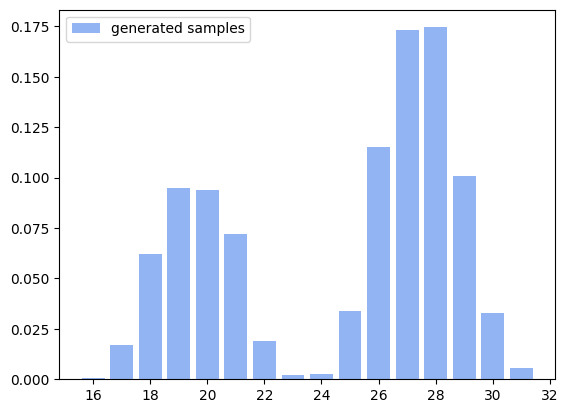

In [14]:
plt.hist(gen, bins=16, align='left', range=[16, 32], rwidth=0.8, density=True, color="cornflowerblue", alpha=0.7, label="generated samples")
plt.legend()
plt.show()

In [15]:
gen_final_positions

array([[-1,  1],
       [ 0, -1],
       [-3,  0],
       ...,
       [ 2, -2],
       [ 1, -1],
       [-2,  0]])

In [16]:
unique_pos = np.unique(gen_final_positions, axis=0)
unique_pos

array([[-4, -4],
       [-4, -3],
       [-4, -2],
       [-4, -1],
       [-4,  0],
       [-4,  1],
       [-4,  2],
       [-3, -4],
       [-3, -3],
       [-3, -2],
       [-3, -1],
       [-3,  0],
       [-3,  1],
       [-3,  2],
       [-3,  3],
       [-2, -4],
       [-2, -3],
       [-2, -2],
       [-2, -1],
       [-2,  0],
       [-2,  1],
       [-2,  2],
       [-2,  3],
       [-1, -4],
       [-1, -3],
       [-1, -2],
       [-1, -1],
       [-1,  0],
       [-1,  1],
       [-1,  2],
       [-1,  3],
       [ 0, -4],
       [ 0, -3],
       [ 0, -2],
       [ 0, -1],
       [ 0,  0],
       [ 0,  1],
       [ 0,  2],
       [ 0,  3],
       [ 1, -4],
       [ 1, -3],
       [ 1, -2],
       [ 1, -1],
       [ 1,  0],
       [ 1,  1],
       [ 1,  2],
       [ 1,  3],
       [ 2, -4],
       [ 2, -3],
       [ 2, -2],
       [ 2, -1],
       [ 2,  0],
       [ 2,  1],
       [ 2,  2],
       [ 2,  3],
       [ 3, -2],
       [ 3, -1],
       [ 3,  0],
       [ 3,  1

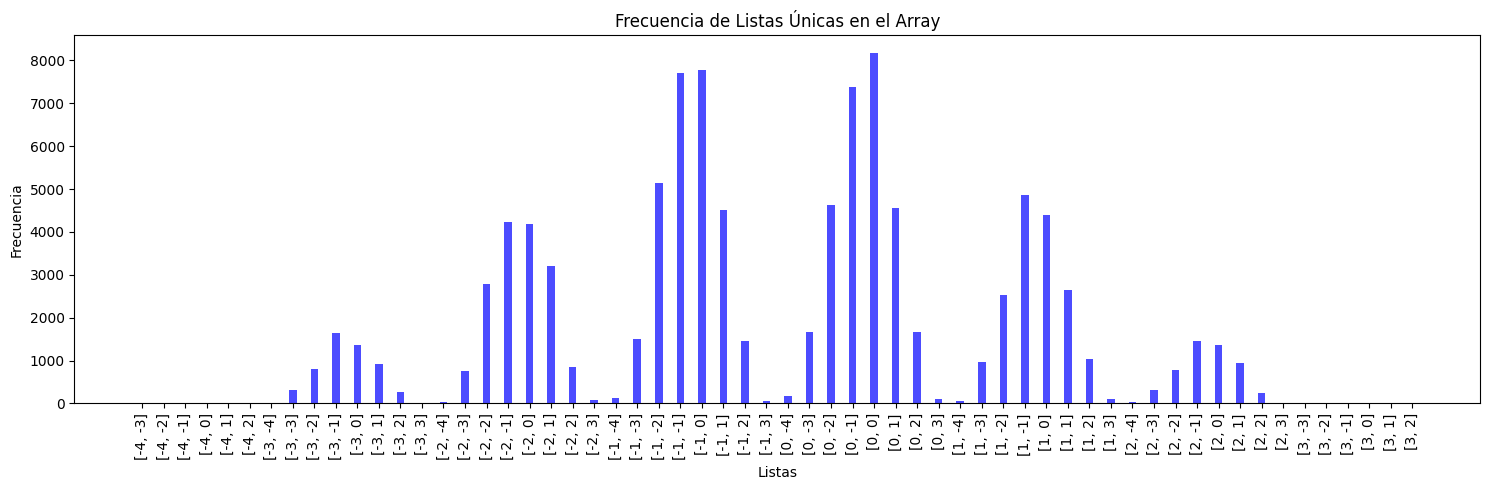

In [17]:
t = np.stack([(gen//8) - 4, (gen%8) - 4]).T

# Encontrar las filas únicas y sus frecuencias
unique_rows, counts = np.unique(t, axis=0, return_counts=True)

# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(15, 5))
bar_width = 0.35

# Etiquetas para las barras
labels = [str(list(row)) for row in unique_rows]

# Crear las barras
ax.bar(labels, counts, bar_width, color='b', alpha=0.7)

# Etiquetas y título del gráfico
ax.set_xlabel('Listas')
ax.set_ylabel('Frecuencia')
ax.set_title('Frecuencia de Listas Únicas en el Array')
ax.set_xticks(labels)
ax.set_xticklabels(labels, rotation=90)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

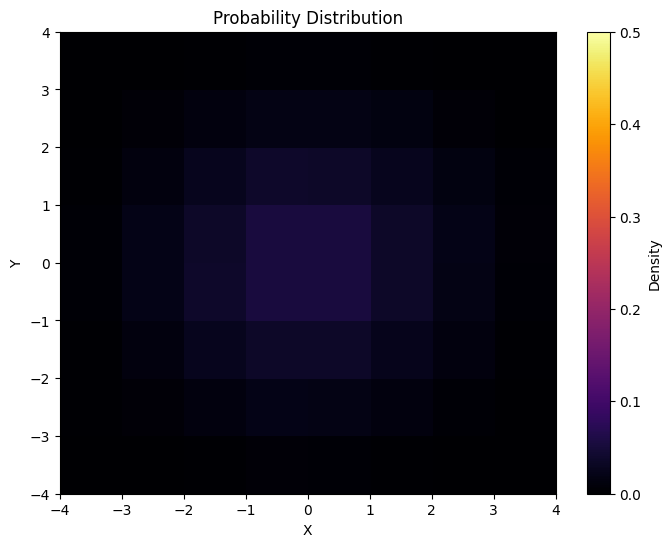

In [18]:
mcs.visualize_distribution_2D(samples=final_positions, limits=(-4, 4), bins=8)

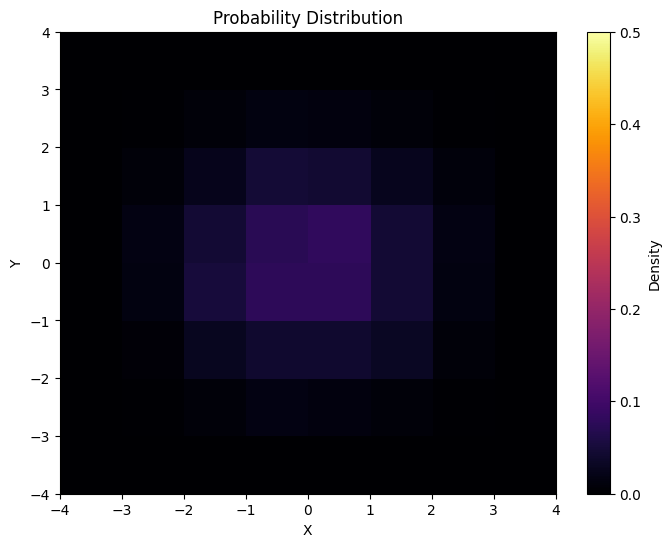

In [19]:
mcs.visualize_distribution_2D(samples=t, limits=(-4, 4), bins=8)